# Approche Bayésienne

In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

/Users/aurianeblarre/miniconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def sigma(z):
    return 1/(1+np.exp(-z))

def logit(z):
    return np.log(z/(1-z))

In [3]:
class modelSparse:
    """Classe qui encapsule l'apprentissage"""
    
    def __init__(self, D, R):
        """Constructeur"""
        
        self.D = D #Nombre de variables explicatives
        self.R = R #Nombre d'annotateurs
     
    
    def chargeData(self, path, recentrage = True):
        """Fonction qui charge les données avec path le chemin du fichier CSV. 
        Par défault, on impose un recentrage des donnée"""
        
        data = pd.read_csv(path, delimiter = ";")
        self.trueLabel = np.array(data.ix[:,self.D])
        self.y = np.array(data.ix[:,self.D+1:]) #labels des annotateurs
        x = np.array(data.ix[:,0:self.D]) #variables explicatives
        if (recentrage):
            self.x = (x -np.mean(x,axis=0))/(np.std(x, axis=0))
        else:
            self.x = x
        self.N = self.y.shape[0] #Nombre de lignes
     
    def initPrior(self,mean_prior1, var_prior1, mean_prior2, var_prior2, gamma_prior):
        """Initialise les a priori sur alpha, beta, et gamma.
        a est un tableau 2xR
        b est un tableau 2xR
        gamma_prior est une matrice de covariance DxD."""
        
        self.a_prior = np.random.rand(2,self.R) 
        self.b_prior = np.random.rand(2,self.R)
        for i in range(0,R):
            self.a_prior[0][i] = (-mean_prior1[i]**3 + mean_prior1[i]**2 -mean_prior1[i]*var_prior1[i]**2)/var_prior1[i]**2
            self.a_prior[1][i] = self.a_prior[0][i]*(1-mean_prior1[i])/mean_prior1[i]
            self.b_prior[0][i] = (-mean_prior2[i]**3 + mean_prior2[i]**2 -mean_prior2[i]*var_prior2[i]**2)/var_prior2[i]**2
            self.b_prior[1][i] = self.b_prior[0][i]*(1-mean_prior2[i])/mean_prior2[i]
        
        self.gamma_prior = gamma_prior
    
    def initMu(self):
        """Initialisation de mu"""
        
        self.mu = []
        for i in range(0,self.N):
            self.mu.append(np.nansum(self.y[i])/self.R)
    
    
    def ai(self):
        """Update du vecteur a (1xN)"""
        
        a = []
        for i in range(0,self.N):
            proda = 1
            for j in range(0,self.R):
                if (np.isnan(self.y[i][j])==False):
                    proda = proda*self.alpha[j]**(self.y[i][j])*(1-self.alpha[j])**(1-self.y[i][j])
            a.append(proda)
        self.a = a
    
    
    def bi(self):
        """Update du vecteur b (1xN)"""
        
        b = []
        for i in range(0,self.N):
            prodb = 1
            for j in range(0,self.R):
                if (np.isnan(self.y[i][j])==False):
                    prodb = prodb*self.beta[j]**(1-self.y[i][j])*(1-self.beta[j])**(self.y[i][j])
            b.append(prodb)
        self.b = b
       
    
    def pi(self):
        """Update du vecteur p (1xN)"""
        
        p = []
        for i in range(0,self.N):
            p.append(sigma(self.x[i].dot(self.w.T)))
        self.p = p
       
    
    def mui(self):
        """Update du vecteur mu (1xN). C'est l'étape E."""
        self.ai()
        self.bi()
        self.pi()
        mu = []
        for i in range(0,self.N):
            mu.append(self.a[i]*self.p[i]/(self.a[i]*self.p[i]+self.b[i]*(1-self.p[i])))
        self.mu = mu        
      
    
    def logLikelihood(self):
        """Calcul de la log-vraissemblance."""
        
        self.ai()
        self.bi()
        self.pi()
    
        #On calcule directement la log-vraissemblance.
        vraissemblance = 0
        for i in range(0,self.N):
            vraissemblance = vraissemblance + np.log((self.a[i]*self.p[i])+self.b[i]*(1-self.p[i]))
        return vraissemblance
    
    
    def alphaUpdate(self):
        """Update du vecteur alpha sensitivity (1xR)"""
        
        alpha = []
        for j in range(0,self.R):
            tmp1 = 0
            tmp2 = 0
            for i in range(0,self.N):
                if (np.isnan(self.y[i][j])==False):
                    tmp1 += self.mu[i]*self.y[i][j]
                    tmp2 += self.mu[i]
            alpha.append((self.a_prior[0][j]-1+tmp1)/(self.a_prior[0][j]+self.a_prior[1][j]-2+tmp2))
        self.alpha = alpha

        
    def betaUpdate(self):
        """Update du vecteur beta specificity (1xR)"""
        
        beta = []
        for j in range(0,self.R):
            tmp1 = 0
            tmp2 = 0
            for i in range(0,self.N):
                if (np.isnan(self.y[i][j])==False):
                    tmp1 += (1-self.mu[i])*(1-self.y[i][j])
                    tmp2 += 1-self.mu[i]
            beta.append((self.b_prior[0][j]-1+tmp1)/(self.b_prior[0][j]+self.b_prior[1][j]-2+tmp2))
        self.beta = beta

        
    def wUpdate(self):
        """Update du vecteur poids w (1xR)"""
        
        g = 0
        for i in range(0,self.N):
            g += (self.mu[i] - sigma(self.x[i].dot(self.w.T)))*self.x[i]
        tmp = np.reshape(-self.gamma_prior.dot(self.w.T),g.shape) # (11,1) -> (11,)
        g += tmp
    
        H = np.zeros((self.D,self.D))
        for i in range(0,self.N):
            H -= sigma(self.x[i].dot(self.w.T))*(1-sigma(self.x[i].dot(self.w.T)))*((self.x[i].reshape(self.D,1))*(self.x[i].reshape(1,self.D)))
        H -= self.gamma_prior
        self.w = self.w - self.eta*np.linalg.inv(H).dot(g)
    
    
    def score(self, seuil = 1/2):
        """Quel est le score d'apprentissage de notre modèle ?"""
        return np.mean(np.equal(self.trueLabel, np.array(self.mu)>seuil))
    
    
    def scoreMoy(self, seuil = 1/2):
        """Quel serait le score si on fesait naïvement la moyenne des avis des annotateurs ?"""
        return np.mean(np.equal(self.trueLabel, np.nanmean(self.y, axis = 1)>seuil))

    
    def train(self, mean_prior1, var_prior1, mean_prior2, var_prior2, gamma_prior, maxIter = 1000, eta = 0.01, epsilon = 1e-10, graphe=True):
        """Fonction qui lance l'entrainement du modèle.
        La variable graphe sert à plotter la log-likelihood au fil des itérations.
        La log-likelihood devrait être croissante."""
        
        self.maxIter = maxIter
        self.eta = eta
        
        self.initPrior(mean_prior1, var_prior1, mean_prior2, var_prior2, gamma_prior)
        self.initMu()
        self.alphaUpdate()
        self.betaUpdate()
        self.w = np.random.rand(1,self.D)

        compteur = 0
        self.histLogLikelihood = []
        
        while (compteur < maxIter):
            self.mui()
            self.alphaUpdate()
            self.betaUpdate()
            wOld = self.w
            self.wUpdate()
            wNew = self.w
            
            self.histLogLikelihood.append(self.logLikelihood())
            diffW = wOld - wNew
            if (np.linalg.norm(diffW) < self.N*epsilon):
                print("SEUIL DE CONVERGENCE SUR W ATTEINT")
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Alpha : ", self.alpha)
                print("Beta : ", self.beta)
                break
            
            if (compteur % 100 == 0):
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Alpha : ", self.alpha)
                print("Beta : ", self.beta)
            compteur = compteur + 1
        
        if graphe:
            plt.plot(self.histLogLikelihood)
            plt.title('Log-vraissemblance au fil des itérations')

    def roc(self) :
        falsePR, truePR, threshold = roc_curve(self.trueLabel, self.mu) #falsePositiveRate and truePositiveRate
        falsePR1, truePR1, threshold1 = roc_curve(self.trueLabel, np.nanmean(self.y, axis = 1))
        roc_auc = auc(falsePR, truePR)
        roc_auc1 = auc(falsePR1, truePR1)
        plt.plot(falsePR, truePR, lw=2, label='ROC - AUC = %0.2f)'%(roc_auc))
        plt.plot(falsePR1, truePR1, lw = 2, label = 'ROC - AUC = %0.2f)'%(roc_auc1))
        plt.legend()

In [4]:
#Paramètres du data set
D = 10
R = 5

In [5]:
#Nos hypothèses
#Sensitivity
mean_prior1 = np.array([0.9, 0.8, 0.4, 0.2, 0.1]) #Quel pourcentage de bonnes réponses l'expert donne en moyenne ?
var_prior1 = np.array([1,1,1,1,1]) #Avec quelle incertitude ?

#Sensibility
mean_prior2 = np.array([0.85, 0.75, 0.45, 0.25, 0.1]) #Quel pourcentage de bonnes réponses l'expert donne en moyenne ?
var_prior2 = np.array([1,1,1,1,1]) #Avec quelle incertitude ?

#Weights
gamma_prior = np.identity(D)

In [6]:
breast = modelSparse(D, R)
breast.chargeData('Datasets/DebugBis.csv')
breast.train(mean_prior1, var_prior1, mean_prior2, var_prior2, gamma_prior,maxIter = 500, eta = 1, graphe = True)

NameError: name 'model' is not defined

ITERATION :  0
Vraissemblance :  [-1544.83233207]
Norme de diff_w :  0.673833381118
Alpha :  [array([ 0.76799883]), array([ 0.78556805]), array([ 0.60414457]), array([ 0.5875114]), array([ 0.53383604])]
Beta :  [array([ 0.92649175]), array([ 0.83988907]), array([ 0.63073755]), array([ 0.62941373]), array([ 0.59429554])]
SEUIL DE CONVERGENCE SUR W ATTEINT
ITERATION :  25
Vraissemblance :  [-1485.73408828]
Norme de diff_w :  4.33244523601e-08
Alpha :  [array([ 0.91379648]), array([ 0.86713804]), array([ 0.61948226]), array([ 0.57927899]), array([ 0.51984699])]
Beta :  [array([ 0.96431574]), array([ 0.8540506]), array([ 0.62494893]), array([ 0.61114518]), array([ 0.57752557])]


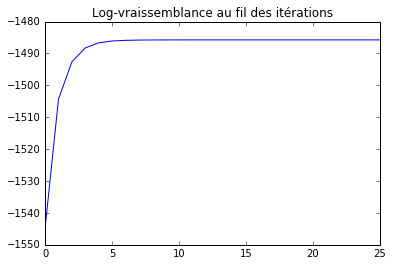

In [7]:
breast = modelSparse(D, R)
breast.chargeData('Datasets/BreastCancer/DB_wdbcSparse.csv')
breast.train(mean_prior1, var_prior1, mean_prior2, var_prior2, gamma_prior,maxIter = 500, eta = 1, graphe = True)

In [32]:
print("LE SCORE D'ENTRAINEMENT EST DE : ", breast.score())
print("LE SCORE NAIF DE MOYENNE DES ANNOTATEURS EST DE : ", breast.scoreMoy())

LE SCORE D'ENTRAINEMENT EST DE :  0.499702558001
LE SCORE NAIF DE MOYENNE DES ANNOTATEURS EST DE :  1.0


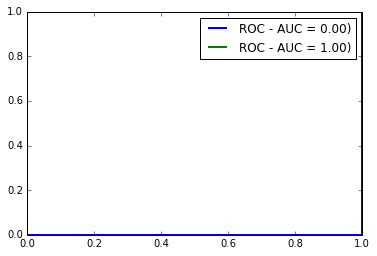

In [33]:
breast.roc()

# LE RESTE EST UN BROUILLON

In [2]:
wine = pd.read_csv('Datasets/whiteWine.csv', delimiter = ";")

In [3]:
d = 11  #descripteurs
N =  wine.shape[0] #produits à tester
R = 5 #experts

y = np.array(wine.ix[:,d+2:]) #labels des annotateurs
x = np.array(wine.ix[:,0:d]) #variables explicatives
w0 = np.random.rand(1,d)

## Initialisation

In [11]:
def init_mu(y):
	mu = []
	for i in range(0,N):
		mu.append(np.sum(y[i])/R)
	return mu

mu0 = init_mu(y)

def sigma(z):
    return 1/(1+np.exp(-z))

def logit(z):
    return np.log(z/(1-z))

In [5]:
#Nos hypothèses
#Sensitivity
mean_prior1 = np.random.rand(R) #Quel pourcentage de bonnes réponses l'expert donne en moyenne ?
var_prior1 = np.random.rand(R) #Avec quelle incertitude ?
#Sensibility
mean_prior2 = np.random.rand(R) #Quel pourcentage de bonnes réponses l'expert donne en moyenne ?
var_prior2 = np.random.rand(R) #Avec quelle incertitude ?
#Weights
gamma_prior = np.random.rand(d,d)

#On en déduit les paramètres 
a_prior = np.random.rand(2,R) 
b_prior = np.random.rand(2,R)
for i in range(0,R):
    a_prior[0][i] = (-mean_prior1[i]**3 + mean_prior1[i]**2 -mean_prior1[i]*var_prior1[i]**2)/var_prior1[i]**2
    a_prior[1][i] = a_prior[0][i]*(1-mean_prior1[i])/mean_prior1[i]
    b_prior[0][i] = (-mean_prior2[i]**3 + mean_prior2[i]**2 -mean_prior2[i]*var_prior2[i]**2)/var_prior2[i]**2
    b_prior[1][i] = b_prior[0][i]*(1-mean_prior2[i])/mean_prior2[i]


gamma_prior = np.linalg.inv(gamma_prior)

## Etape E

In [6]:
#E-step

def ai(alpha,y):
    a = []
    for i in range(0,N):
        proda = 1
        for j in range(0,R):
            proda = proda*alpha[j]**(y[i][j])*(1-alpha[j])**(1-y[i][j])
        a.append(proda)
    return a

def bi(beta,y):
    b = []
    for i in range(0,N):
        prodb = 1
        for j in range(0,R):
            prodb = prodb*beta[j]**(1-y[i][j])*(1-beta[j])**(y[i][j])
        b.append(prodb)
    return b

def pi(x,w):
    p = []
    for i in range(0,N):
        p.append(sigma(x[i].dot(w.T)))
    return p

def mui(a,b,p):
    mu = []
    for i in range(0,N):
        mu.append(a[i]*p[i]/(a[i]*p[i]+b[i]*(1-p[i])))
    return mu

def E_step(x,y,alpha,beta,w):
    a = ai(alpha,y)
    b = bi(beta,y)
    p = pi(x,w)
    mu = mui(a,b,p)
    return mu


## Maximum Log - Likelihood Estimator

In [7]:
def logLikelihood(w, y, alpha, beta):
    a = ai(alpha, y)
    b = bi(beta, y)
    p = pi(x, w)
    
    #On calcule directement la log-vraissemblance.
    vraissemblance = 0
    for i in range(0,N):
        vraissemblance = vraissemblance + np.log((a[i]*p[i])+b[i]*(1-p[i]))
        
    return vraissemblance

## Étape M

In [8]:
#M-step

def alpha_function(mu,y,a_prior):
	alpha = []
	for j in range(0,R):
		tmp1 = 0
		tmp2 = 0
		for i in range(0,N):
			tmp1 += mu[i]*y[i][j]
			tmp2 += mu[i]
		alpha.append((a_prior[0][j]-1+tmp1)/(a_prior[0][j]+a_prior[1][j]-2+tmp2))
	return alpha

def beta_function(mu,y,b_prior):
	beta = []
	for j in range(0,R):
		tmp1 = 0
		tmp2 = 0
		for i in range(0,N):
			tmp1 += (1-mu[i])*(1-y[i][j])
			tmp2 += 1-mu[i]
		beta.append((b_prior[0][j]-1+tmp1)/(b_prior[0][j]+b_prior[1][j]-2+tmp2))
	return beta

def updateW(w,x, eta, mu, gamma_prior):
    g = 0
    for i in range(0,N):
        g += (mu[i] - sigma(x[i].dot(w.T)))*x[i]
    tmp = np.reshape(-gamma_prior.dot(w.T),g.shape) # (11,1) -> (11,)
    g += tmp
    
    H = np.zeros((d,d))
    for i in range(0,N):
        H -= sigma(x[i].dot(w.T))*(1-sigma(x[i].dot(w.T)))*((x[i].reshape(11,1))*(x[i].reshape(1,11)))
    H -= gamma_prior
    w = w - eta*np.linalg.inv(H).dot(g)
    return w

In [9]:
updateW(w0,x,0.1,mu0,gamma_prior)

array([[-35334.92901159, -28871.41002449, -37022.64471383, -24159.64331136,
        -33242.01854823, -20056.53651041, -34332.7256707 ,  -6830.87748493,
        -27080.53161824, -13806.67227696, -20106.51189462]])

## Itérations

In [10]:
mu = init_mu(y)
alpha = alpha_function(mu,y,a_prior)
beta = beta_function(mu,y,b_prior)
diff_w = 10
w = w0

compteur = 0

#while (np.linalg.norm(diff_w) > 0.001) : # Limite de convergence à decider
while (compteur < 100):
    mu = E_step(x,y,alpha,beta,w)
    alpha = alpha_function(mu,y,a_prior)
    beta = beta_function(mu,y,b_prior)
    w_bis = updateW(w,x,0.01,mu,gamma_prior)
    diff_w = w - w_bis
    w = w_bis
    if (compteur % 10 == 0):
        print ("ITERATION : ", compteur)
        print("Vraissemblance : ", logLikelihood(w, y, alpha, beta))
        print("Norme de diff_w : ", np.linalg.norm(diff_w))
        print("Alpha : ", alpha)
        print("Beta : ", beta)
    compteur = compteur + 1

ITERATION :  0
Vraissemblance :  [-12941.84181545]
Norme de diff_w :  0.0189439655636
Alpha :  [array([ 0.89419982]), array([ 0.70627847]), array([ 0.51154001]), array([ 0.40361302]), array([ 0.1026994])]
Beta :  [array([ 0.4933009]), array([ 0.39185742]), array([ 0.55288447]), array([ 0.55593145]), array([ 0.84461565])]
ITERATION :  10
Vraissemblance :  [-12941.84181559]
Norme de diff_w :  0.0171301718401
Alpha :  [array([ 0.89419982]), array([ 0.70627847]), array([ 0.51154001]), array([ 0.40361302]), array([ 0.1026994])]
Beta :  [array([ 0.49330092]), array([ 0.39185747]), array([ 0.55288447]), array([ 0.55593144]), array([ 0.84461576])]
ITERATION :  20
Vraissemblance :  [-12941.84181615]
Norme de diff_w :  0.0154828695169
Alpha :  [array([ 0.89419982]), array([ 0.70627847]), array([ 0.51154001]), array([ 0.40361302]), array([ 0.1026994])]
Beta :  [array([ 0.49330103]), array([ 0.39185767]), array([ 0.55288445]), array([ 0.55593141]), array([ 0.84461627])]
ITERATION :  30
Vraissembla

In [29]:
#weight of each expert
weights = logit(np.array(alpha))+logit(np.array(beta))

#Sensitivity and sensibility of classifiers
alpha_clas = []
beta_clas = []
for j in range(0,d):
    tmp = 0
    tmp2 = 0
    for i in range(0,N):
        tmp += mu[j]*x[i][j]
        tmp2 += (1-mu[j])*(1-x[i][j])
    alpha_clas.append(tmp/np.sum(mu))
    beta_clas.append(tmp2/(N-np.sum(mu)))
alpha_clas = np.array(alpha_clas)
beta_clas = np.array(beta_clas)


[[  6.85478903e+00]
 [  2.78241174e-01]
 [  3.34191573e-01]
 [  6.39141613e+00]
 [  4.57723652e-02]
 [  3.53080920e+01]
 [  1.38360685e+02]
 [  9.94027574e-01]
 [  3.18826727e+00]
 [  4.89846974e-01]
 [  1.05142691e+01]] [[  0.00000000e+00]
 [  0.00000000e+00]
 [  1.85919375e-09]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [ -2.10763051e-07]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [ -3.53501284e-03]]


In [ ]:
class model:
    """Classe qui encapsule l'apprentissage"""
    
    def __init__(self, maxIter = 10000, eta = 0.01):
        """Constructeur"""
        self.maxIter = maxIter
        self.eta = eta
        
    def initMu(self, y):
        """Initialisation de mu"""
        mu = []
        for i in range(0,N):
            mu.append(np.sum(y[i])/R)
        return mu
    
    def ai(self, alpha, y):
        """Update du vecteur a (1xN)"""
        a = []
        for i in range(0,N):
            proda = 1
        for j in range(0,R):
            proda = proda*alpha[j]**(y[i][j])*(1-alpha[j])**(1-y[i][j])
            a.append(proda)
        self.a = a
        
    def bi(self, beta, y):
        """Update du vecteur b (1xN)"""
        b = []
        for i in range(0,N):
            prodb = 1
        for j in range(0,R):
            prodb = prodb*beta[j]**(1-y[i][j])*(1-beta[j])**(y[i][j])
            b.append(prodb)
        self.b = b
        
    def pi(self, x, w):
        """Update du vecteur p (1xN)"""
        p = []
        for i in range(0,N):
            p.append(sigma(x[i].dot(w.T)))
        self.p = p
        
    def mui(self, a,b,p):
        """Update de"""
        mu = []
        for i in range(0,N):
            mu.append(a[i]*p[i]/(a[i]*p[i]+b[i]*(1-p[i])))
        self.mu = mu
    
    def EStep(x,y,alpha,beta,w):
        CE = 0 #Conditionnal excepectation
        a = ai(alpha,y)
        b = bi(beta,y)
        p = pi(x,w)
        mu = mui(a,b,p)
        for i in range(0,N):
            CE += mu[i]*np.log(p[i])*a[i]+(1-mu[i])*np.log(1-p[i])*b[i]
        